In [1]:
import numpy as np

def divide_three_classes(img, n_classes=3):
	multiclass = np.zeros((*img.shape,n_classes), dtype=np.float32)
	
	body = np.where(img<0.4, 1., 0.)
	marker = np.where((img<0.75)&(img>=0.4), 1., 0.)
	wound = np.where(img >= 0.75, 1., 0.)

	multiclass[:,:,0] = body
	multiclass[:,:,1] = marker
	multiclass[:,:,2] = wound

	return multiclass

In [2]:
import cv2

label_3 = cv2.imread('./test_data/20250605_000003.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.

False

## preparing real datasets for training

In [1]:
import os
import random
from glob import glob

FOLDS_NUMER = 6
IMGS_X_FOLDER = 909

random.seed(346)

list_imgs = glob('../data/segmented/*.png')
random.shuffle(list_imgs)

assert len(list_imgs)//FOLDS_NUMER > IMGS_X_FOLDER


In [11]:
import pandas as pd

data = pd.DataFrame({'file' : list_imgs[:IMGS_X_FOLDER], 'folder' : [0]*IMGS_X_FOLDER})

for i in range(1,FOLDS_NUMER):
  new_rows = pd.DataFrame({'file' : list_imgs[i*IMGS_X_FOLDER:(i+1)*IMGS_X_FOLDER], 'folder' : [i]*IMGS_X_FOLDER})
  data = pd.concat([data,new_rows]).reset_index(drop=True)

data

,file,folder
0,../data/segmented/-M2Xp0A2psHObp6f7Iav.-M2XpBj...,0
1,../data/segmented/-NaQsMwhq2FAV8U5jYdh.-NaQtYF...,0
2,../data/segmented/-MN2hxShPEnW3ZwMc7YZ.-Ms4LJB...,0
3,../data/segmented/-Leujocx_cjh-Ci6MrBu.-Mkq3mZ...,0
4,../data/segmented/-MIOBNUgcr0MTphTegMf.-MIOBfY...,0
...,...,...
5449,../data/segmented/-NZz-yrFJIgMkrvvyU7k.-NZz054...,5
5450,../data/segmented/-LiwHS89iphwTuLVEkcv.-LiwHZm...,5
5451,../data/segmented/-MX_tivv7eIFmiM5It8l.-MX_trj...,5
5452,../data/segmented/-NKqt26V9R-mBxkxU81X.-NKrFM2...,5


In [20]:
import os
import cv2

import numpy as np
from tqdm.auto import tqdm



for i in range(FOLDS_NUMER):
  saving_folder = f'./train_data_real{i}/'
  os.makedirs(saving_folder, exist_ok=True)
  saving_wound = saving_folder + 'wound/'
  saving_sem_mask = saving_folder + 'semantic_masks/'
  os.makedirs(saving_wound, exist_ok=True)
  os.makedirs(saving_sem_mask, exist_ok=True)
  
  data_folder = '../data/segmented/'
  wound_mask = '../data/masks/'
  body_mask = '../data/body_mask/'
  marker_mask = '../data/marker_mask/'

  rows = (data['folder']==i)

  for file in tqdm(data[rows]['file']):
    f = file.split('/')[-1]
    img = cv2.imread(data_folder+f)
    wound = cv2.imread(wound_mask+f, cv2.IMREAD_GRAYSCALE)
    body = cv2.imread(body_mask+f, cv2.IMREAD_GRAYSCALE)
    if os.path.exists(marker_mask+f):
      marker = cv2.imread(marker_mask+f, cv2.IMREAD_GRAYSCALE)
    else:
      marker = None

    semantic = np.zeros_like(wound).astype(np.float32)
    semantic = np.where(body!=0, np.ones_like(wound)*(1/3), semantic)
    semantic = np.where(wound!=0, np.ones_like(wound), semantic)
    if marker is not None:
      semantic = np.where(marker!=0, np.ones_like(wound)*(2/3), semantic)

    semantic = (semantic*255).astype(np.uint8)

    cv2.imwrite(saving_sem_mask+f, semantic)
    cv2.imwrite(saving_wound+f, img)








  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

  0%|          | 0/909 [00:00<?, ?it/s]

# Analyse losses

In [102]:
import pandas as pd
import os
from glob import glob

losses_paths = [n + '/lossi.csv' for n in glob('saved_models/u2net_*')]
models_names = [n.split('/')[1].split('_')[-1] for n in losses_paths]



In [99]:
pd.read_csv(losses_paths[0])['0'].values

dict_loss = {}

for name, path in zip(models_names, losses_paths):
  lossi = pd.read_csv(path)['0'].values[::100]
  dict_loss[name] = lossi

lossis = pd.DataFrame(dict_loss)


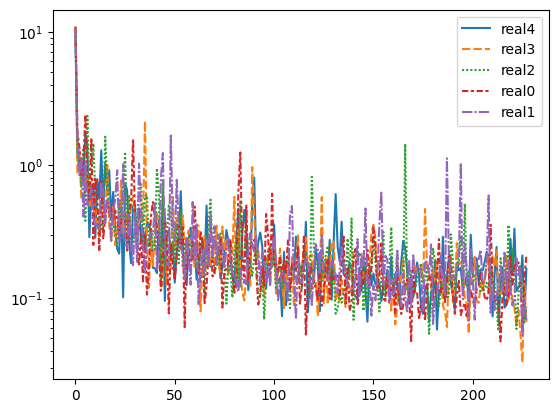

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=lossis)
plt.yscale('log')

# Testing the synthetic model

In [110]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import ToTensorLab
from data_loader import SemanticSalObjDataset

from glob import glob

salobj_dataset = SemanticSalObjDataset(
  img_name_list=glob('train_data_real/train_data_real0/wound/*.png'),
  lbl_name_list=glob('train_data_real/train_data_real0/semantic_mask/*.png'),
  transform=transforms.Compose([
    RescaleT(320),
    RandomCrop(288),
    ToTensorLab(flag=0)]))

dataloader = DataLoader(salobj_dataset, batch_size=1, shuffle=True)


In [113]:
import torch
from model import SU2NET

model = SU2NET()

model.load_state_dict(torch.load('saved_models/u2net_synth/u2net_bce_itr_80_train_4.851859_tar_0.686198.pth', map_location='cpu'))
model.eval()

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


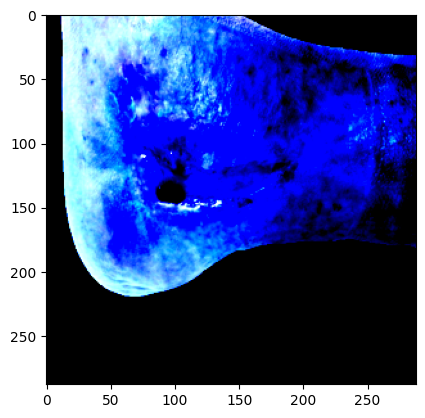

(tensor(0.), tensor(0.3333))

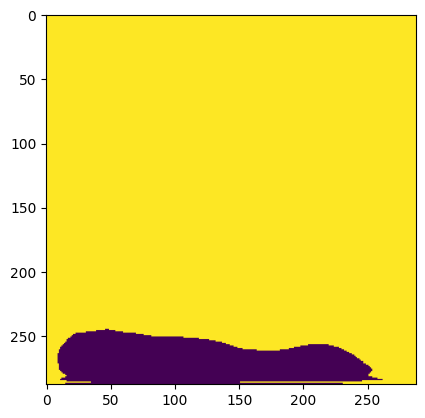

In [118]:
import matplotlib.pyplot as plt

def normPRED(d):
  semantic_layer = torch.argmax(d, dim=0)
  return semantic_layer/3.

with torch.no_grad():

  data = next(iter(dataloader))
  img = data['image'].type(torch.float32)
  gt = data['label'].type(torch.float32)


  out, *_ = model(img)
  pred = torch.nn.functional.softmax(torch.squeeze(out), dim=0) # non sono sicuro che la dim giusta sia 0... may a bug
  pred = normPRED(pred)

plt.imshow(img.squeeze().permute(1,2,0))
plt.show()
plt.imshow(pred)
pred.min(), pred.max()


In [36]:
img

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 0.9118,  0.9870,  0.9091,  ...,  0.5005,  0.8238,  1.2119],
          [ 0.9615,  0.9542,  0.8983,  ...,  0.5176,  0.6670,  1.3489],
          [ 0.8777,  0.9034,  0.8894,  ...,  0.4047,  0.8061,  1.3609]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 0.9853,  1.1341,  1.0370,  ...,  0.6055,  0.9890,  1.3201],
          [ 1.0573,  1.1316,  1.0743,  ...,  0.5907,  0.7905,  1.4350],
          [ 1.0033,  1.1108,  1.1057,  ...,  0.3997,  0.8477,  1.3810]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

# Validation

In [2]:
import os
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as standard_transforms

import pandas as pd
import numpy as np
import glob
import os

from data_loader import Rescale
from data_loader import RescaleT
from data_loader import RandomCrop
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SemanticSalObjDataset

from model import SU2NET
from model import SU2NETP

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Device: {device}')

Device: cpu


In [71]:
# creating list of images and dataloaders

models_numbers = [0,1,2,3,4,5]


EVAL_MODEL_N = 0


models_numbers.remove(EVAL_MODEL_N)

test_img_list = []
test_lbl_list = []

for i in models_numbers:
  temp_list_img = glob.glob(f'train_data_real/train_data_real{i}' + os.sep + 'wound' + os.sep + '*.png')
  temp_list_lbl = glob.glob(f'train_data_real/train_data_real{i}' + os.sep + 'semantic_masks' + os.sep + '*.png')

  test_img_list += temp_list_img
  test_lbl_list += temp_list_lbl

del temp_list_img, temp_list_lbl
print(f'Found {len(test_img_list)} images and {len(test_lbl_list)} masks')


salobj_dataset = SemanticSalObjDataset(
  img_name_list=test_img_list[:10],
  lbl_name_list=test_lbl_list[:10],
  transform=transforms.Compose([
    RescaleT(320),
    RandomCrop(288),
    ToTensorLab(flag=0)]))

salobj_dataloader = DataLoader(salobj_dataset, 
                                batch_size=1, 
                                shuffle=False,
                                pin_memory=True,
                                #num_workers=8,
                                )


Found 4545 images and 4545 masks


In [72]:
# importing the model

model = SU2NET(in_ch=3, out_ch=4).to(device)
model.eval()

models_paths = glob.glob(f'saved_models/u2net_real{EVAL_MODEL_N}/u2net_bce_itr_100*')
assert len(models_paths)==1

model.load_state_dict(torch.load(models_paths[0], map_location=device))


<All keys matched successfully>

In [105]:
EPS = 1e-6

def compute_metrics(one_hot, lable, layers, d):
  if len(layers)>1:
    pred = one_hot[layers[0]]
    gt = lable[layers[0]]
    for l in layers[1:]:
      pred += one_hot[l]
      gt += lable[l]
  else:
    pred = one_hot[layers]
    gt = lable[layers]

  tp = (pred*gt).sum()
  fp = (pred*torch.logical_not(gt)).sum()
  tn = (torch.logical_not(pred)*torch.logical_not(gt)).sum()
  fn = (torch.logical_not(pred)*gt).sum()
  tot = tp+fp+tn+fn

  assert tot == torch.ones_like(pred).sum()

  d['precision'].append(((tp+EPS)/(tp+fp+EPS)).item())
  d['recall'].append(((tp+EPS)/(tp+fn+EPS)).item())
  d['accuracy'].append(((tp+tn+EPS)/tot).item())
  d['dice'].append(((2*tp+EPS)/(2*tp+fp+fn+EPS)).item())
  d['iou'].append(((tp+EPS)/(tp+fp+fn+EPS)).item())

  return d

  

In [113]:
# metrics computation
from tqdm.auto import tqdm

wound_metrics = {'image':[], 'precision':[], 'recall':[], 'accuracy':[], 'dice':[], 'iou':[]}
body_wound_marker_metrics = {'image':[], 'precision':[], 'recall':[], 'accuracy':[], 'dice':[], 'iou':[]}
marker_metrics = {'image':[], 'precision':[], 'recall':[], 'accuracy':[], 'dice':[], 'iou':[]}
body_marker_no_wound_metrics = {'image':[], 'precision':[], 'recall':[], 'accuracy':[], 'dice':[], 'iou':[]}
body_only_metrics = {'image':[], 'precision':[], 'recall':[], 'accuracy':[], 'dice':[], 'iou':[]}

with torch.no_grad():
  for data in tqdm(salobj_dataloader):
    inputs, labels = torch.tensor(data['image'], device=device, dtype=torch.float32), torch.tensor(data['label'], device=device, dtype=torch.float32)

    d1,d2,d3,d4,d5,d6,d7= model(inputs)

    # normalization
    dim = 1

    # adding image path
    wound_metrics['image'].append(test_img_list[data['imidx']])
    body_wound_marker_metrics['image'].append(test_img_list[data['imidx']])
    marker_metrics['image'].append(test_img_list[data['imidx']])
    body_marker_no_wound_metrics['image'].append(test_img_list[data['imidx']])
    body_only_metrics['image'].append(test_img_list[data['imidx']])


    indices = torch.argmax(d1, dim=dim)
    one_hot = torch.nn.functional.one_hot(indices, num_classes=d1.size(dim)).bool().permute((0,3,1,2)).squeeze()
    
    indices_lbl = torch.argmax(labels, dim=dim)
    labels = torch.nn.functional.one_hot(indices_lbl, num_classes=d1.size(dim)).bool().permute((0,3,1,2)).squeeze()


    wound_metrics = compute_metrics(one_hot, labels, layers=[3], d=wound_metrics)
    body_wound_marker_metrics = compute_metrics(one_hot, labels, layers=[1,2,3], d=body_wound_marker_metrics)
    marker_metrics = compute_metrics(one_hot, labels, layers=[2], d=marker_metrics)
    body_marker_no_wound_metrics = compute_metrics(one_hot, labels, layers=[1,2], d=body_marker_no_wound_metrics)
    body_only_metrics = compute_metrics(one_hot, labels, layers=[1], d=body_only_metrics)


os.makedirs('metrics/')
os.makedirs(f'metrics/model_real{EVAL_MODEL_N}/')
pd.DataFrame(wound_metrics).to_csv(f'metrics/model_real{EVAL_MODEL_N}/wound.csv')
pd.DataFrame(body_wound_marker_metrics).to_csv(f'metrics/model_real{EVAL_MODEL_N}/body_wound_marker.csv')
pd.DataFrame(marker_metrics).to_csv(f'metrics/model_real{EVAL_MODEL_N}/marker.csv')
pd.DataFrame(body_marker_no_wound_metrics).to_csv(f'metrics/model_real{EVAL_MODEL_N}/body_marker_no_wound.csv')
pd.DataFrame(body_only_metrics).to_csv(f'metrics/model_real{EVAL_MODEL_N}/body_only.csv')



/Users/tommygiak/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/z8/rvmhfb8s3bgcrgvdnv2804th0000gn/T/ipykernel_6557/899860348.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = torch.tensor(data['image'], device=device, dtype=torch.float32), torch.tensor(data['label'], device=device, dtype=torch.float32)
/Users/tommygiak/Documents/wounds/U-2-Net/model/SemU2Net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


In [24]:
labels[(labels<1)&(labels>0)]
labels[1].sum()+labels[3].sum(), (labels[1]+labels[3]).sum()


(tensor(31218), tensor(31218))

In [41]:
data = next(iter(salobj_dataloader))

/Users/tommygiak/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


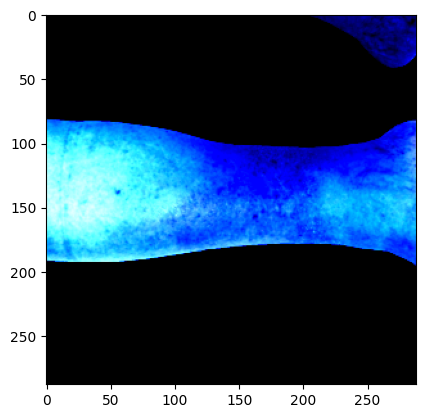

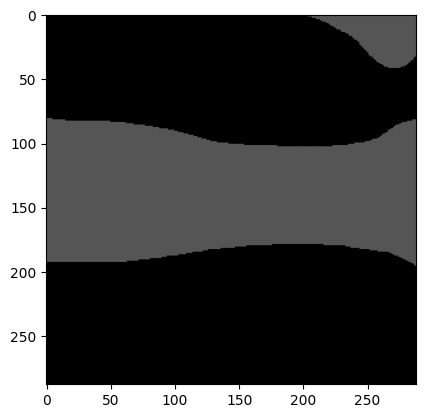

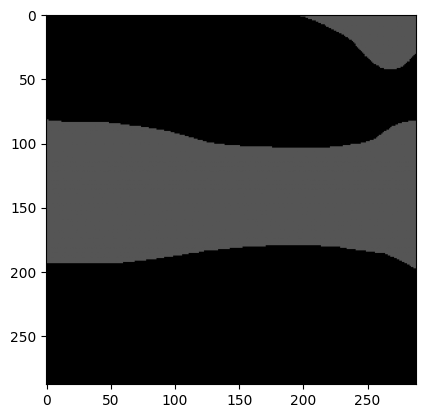

In [66]:
import matplotlib.pyplot as plt
plt.imshow(data['image'][0].permute(1,2,0))
plt.show()


# normalize the predicted SOD probability map
def normPRED(d):
  semantic_layer = torch.argmax(d, dim=0)

  return semantic_layer/3.

out = data['label']
out = normPRED(out[0])
plt.imshow(out,cmap='gray',vmin=0,vmax=1)
plt.show()

d1,d2,d3,d4,d5,d6,d7= model(inputs)
out = normPRED(d1[0].detach())
plt.imshow(out,cmap='gray',vmin=0,vmax=1)
plt.show()